In [4]:
#Importing packages
from selenium import webdriver
import pandas as pd
from bs4 import BeautifulSoup
import time
import xlsxwriter
import csv
import re
from collections import OrderedDict
import currency as cr#to get the currency symbol for easy readibility in the excel file.

In [5]:
#download the driver from the following page
#https://chromedriver.storage.googleapis.com/index.html?path=2.42/
driver = webdriver.Chrome(executable_path=r'C:\Users\Najib\Downloads\Compressed\chromedriver_win32/chromedriver.exe')

In [6]:
currencies={'GBP':[],'AUD':[],'NZD':[],'SGD':[],'CHF':[],'JPY':[],'CAD':[],'USD':[],'CNY':[],'HKD':[],'IDR':[]}# the currencies to be scraped in a dictoniary with empty contents
dates=[]
writer=pd.ExcelWriter('currencies.xlsx', engine='xlsxwriter',options={'strings_to_numbers': True})#file name,engine and convert strings scraped from the yahoo website to numbers for easy readibility and analysis later on

In [7]:
def get_data(s):
    title=s.find('h1').text#find the currencies in each table
    title=title.split()
    header=title[1]#find the currencies to compare
    name=title[0]#get the currency the money is in
    date=s.find_all('td',{"class":"Py(10px) Ta(start) Pend(10px)"})#get all the dates
    dates=[d.get_text() for d in date]#get the text from the date
    data=s.find('div',{"class":"Pb(10px) Ovx(a) W(100%)"})#get all the data
    columns=data.find_all('tr',{"class":"BdT Bdc($seperatorColor) Ta(end) Fz(s) Whs(nw)"})#find the row for each data
    column_data=[column for column in columns]#get all the values
    date_data=[]#empty list of dates
    opens=[]#empty list of open data
    highs=[]#empty list of highs
    lows=[]#empty list of lows
    closes=[]#empty list of closes
    for  cel,d in zip(column_data,dates):#for all the historical dates and values for a currencies

        name=name.split('/')#split the name of the currencie to just get the name of the currencies to be used for symbol
        name=name[0]
        name=name.strip()
        cel=cel.find_all(class_="Py(10px) Pstart(10px)")#get the td inside each cell
        cel_data=[c.get_text() for c in cel]
        date_data.append(d)
        symbol=cr.symbol(name,native=False)#get the symbol
        opens.append(cel_data[0])#append   open data to opens list
        highs.append( cel_data[1])#append   high to highs list
        lows.append( cel_data[2])#append lows data to low list
        closes.append( cel_data[3])#append closes data to closes list
   
    return date_data,opens,highs,lows,closes,header,symbol

In [8]:
def write_excel(date_,open_data,high_data,low_data,close_data,header,symbol):
    #convert from list of list to a list and append the currency symbol to the data
    open_data=[symbol + " " + open for open in open_data]
    high_data=[symbol + " " + high for high in high_data]
    low_data=[symbol + " " +  low for low in low_data]
    close_data=[symbol + " " + close for close in close_data]
    # put the data in a pandas dataframe
    ex=pd.DataFrame({
        "Date":date_,
        "Opened at":open_data,
        "Highest":high_data,
        "Lowest":low_data,
        "Closed":close_data,
    })
    ex.to_excel(writer,sheet_name=header,index=False)#write data to file with each currency as specific worksheet 
    # the following lines of code deal with the column length of the excel file for easy readibility
    worksheet = writer.sheets[header]  # pull worksheet object
    for idx, col in enumerate(ex):  # loop through all columns
        series = ex[col]
        max_len = max((
            series.astype(str).map(len).max(),  # len of largest item
            len(str(series.name))  # len of column name/header
            )) + 1  # adding a little extra space
        worksheet.set_column(idx, idx, max_len)  # set column width

In [9]:
if __name__ == '__main__':
    for currency in currencies.keys():
        link=f"https://finance.yahoo.com/quote/MYR{currency}%3DX/history?period1=1070236800&period2=1594252800&interval=1d&filter=history&frequency=1d"
        driver.get(link)
        for i in range(0,150):
         driver.execute_script("window.scrollBy(0,5000)")
        soup=BeautifulSoup(driver.page_source, 'html.parser')
        dates,opens,highs,lows,closes,header,symbol=get_data(soup)
        data=[d for d in closes]
        currencies[currency]=data
        write_excel(dates,opens,highs,lows,closes,header,symbol)
        print(len(data), len(dates))
        time.sleep(20)#sleep for 20 seconds to not appear suspicious to the website
    dic=dic=OrderedDict(currencies)#convert the dictionary into an ordered dictionary
    dic["Date"]=dates#put the date list into the ordered dictionary
    dic.move_to_end("Date",False)#move the date into the first column
    df = pd.DataFrame.from_dict(dic)
    df.to_csv('currencies.csv',index=False)#write data to a csv
    writer.save()
        

100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100
100 100


In [10]:
import numpy as np

In [42]:
analyzer=pd.read_csv("currencies.csv")#create a pandas data frame for analyzing the scraped data from the csv

In [43]:
analyzer.head()

,Date,GBP,AUD,NZD,SGD,CHF,JPY,CAD,USD,CNY,HKD,IDR
0,"Jul 08, 2020",0.1872,0.3367,0.3563,-,0.2207,25.2328,0.3179,0.2344,1.6454,1.8227,"3,374.8201"
1,"Jul 07, 2020",0.1872,0.3367,0.3572,-,0.2203,25.1441,0.3180,0.2340,1.6381,1.8116,"3,328.9199"
2,"Jul 06, 2020",0.1872,0.3356,0.3564,-,0.2205,25.1362,0.3170,0.2339,1.6412,1.8144,"3,326.0901"
3,"Jul 05, 2020",0.1872,0.3360,0.3566,-,0.2206,25.1182,0.3164,0.2334,1.6482,1.8094,"3,336.5000"
4,"Jul 02, 2020",0.1872,0.3360,0.3585,-,0.2198,24.9905,0.3155,0.2335,1.6408,1.8017,"3,324.7100"


In [44]:
col_names=analyzer.columns.values.tolist()# get all the column names in the csv file and convert into a list 
col_names

['Date',
 'GBP',
 'AUD',
 'NZD',
 'SGD',
 'CHF',
 'JPY',
 'CAD',
 'USD',
 'CNY',
 'HKD',
 'IDR']

In [48]:
#analyzer.columns.map(str.upper,col_names)# make all the columns into an uppercase
analyzer.columns = map(lambda x: str(x).upper(), col_names)
analyzer.rename(columns=lambda x:x+"_MYR",inplace=True)#for all the column names in the dataframe add _MYR
analyzer.rename(columns={"DATE_MYR":"Date"},inplace=True)#rename the date column to just Date

In [49]:
analyzer

,Date,GBP_MYR,AUD_MYR,NZD_MYR,SGD_MYR,CHF_MYR,JPY_MYR,CAD_MYR,USD_MYR,CNY_MYR,HKD_MYR,IDR_MYR
0,"Jul 08, 2020",0.1872,0.3367,0.3563,-,0.2207,25.2328,0.3179,0.2344,1.6454,1.8227,"3,374.8201"
1,"Jul 07, 2020",0.1872,0.3367,0.3572,-,0.2203,25.1441,0.3180,0.2340,1.6381,1.8116,"3,328.9199"
2,"Jul 06, 2020",0.1872,0.3356,0.3564,-,0.2205,25.1362,0.3170,0.2339,1.6412,1.8144,"3,326.0901"
3,"Jul 05, 2020",0.1872,0.3360,0.3566,-,0.2206,25.1182,0.3164,0.2334,1.6482,1.8094,"3,336.5000"
4,"Jul 02, 2020",0.1872,0.3360,0.3585,-,0.2198,24.9905,0.3155,0.2335,1.6408,1.8017,"3,324.7100"
...,...,...,...,...,...,...,...,...,...,...,...,...
95,"Feb 27, 2020",0.1872,0.3615,0.3765,-,0.2311,26.1182,0.3158,0.2368,1.6593,1.8442,"3,297.3101"
96,"Feb 26, 2020",0.1872,0.3589,0.3736,-,0.2314,26.1443,0.3148,0.2363,1.6606,1.8466,"3,284.8101"
97,"Feb 25, 2020",0.1872,0.3586,0.3730,-,0.2324,26.2897,0.3152,0.2368,1.6652,1.8482,"3,292.9600"
98,"Feb 24, 2020",0.1872,0.3620,0.3774,-,0.2341,26.6840,0.3170,0.2389,1.6797,1.8637,"3,296.8401"


In [50]:
analyzer.replace('-',np.nan)#some cells in the csv have - to show that no data was available for that data, replace this with numpy nan
analyzer=analyzer.dropna().reset_index(drop=True)#drop all the null cells in the dataframe
analyzer.isna().sum()

Date       0
GBP_MYR    0
AUD_MYR    0
NZD_MYR    0
SGD_MYR    0
CHF_MYR    0
JPY_MYR    0
CAD_MYR    0
USD_MYR    0
CNY_MYR    0
HKD_MYR    0
IDR_MYR    0
dtype: int64

In [51]:
analyzer.dtypes
#convert all the columns into pandas numerical values
for col in analyzer.columns[1:]:
  analyzer[col]=pd.to_numeric(analyzer[col],errors="coerce")

In [52]:
#convert the Date column into pandas datatime and generate Month_Year column
analyzer["Date"]=pd.to_datetime(analyzer["Date"])
analyzer["Month"]=analyzer["Date"].dt.month
analyzer["Year"]=analyzer["Date"].dt.year
analyzer["Month_Year"]=analyzer["Date"].dt.to_period('M')

In [20]:
analyzer.head()

,Date,GBP,AUD,NZD,SGD,CHF,JPY,CAD,USD,CNY,HKD,IDR,Month,Year,Month_Year
0,2020-07-08,0.1872,0.3367,0.3563,NaN,0.2207,25.2328,0.3179,0.2344,1.6454,1.8227,NaN,7,2020,2020-07
1,2020-07-07,0.1872,0.3367,0.3572,NaN,0.2203,25.1441,0.3180,0.2340,1.6381,1.8116,NaN,7,2020,2020-07
2,2020-07-06,0.1872,0.3356,0.3564,NaN,0.2205,25.1362,0.3170,0.2339,1.6412,1.8144,NaN,7,2020,2020-07
3,2020-07-05,0.1872,0.3360,0.3566,NaN,0.2206,25.1182,0.3164,0.2334,1.6482,1.8094,NaN,7,2020,2020-07
4,2020-07-02,0.1872,0.3360,0.3585,NaN,0.2198,24.9905,0.3155,0.2335,1.6408,1.8017,NaN,7,2020,2020-07


In [55]:
analyzer["GBP_MYR"].count()

100

In [56]:
#generate a column that takes the mean of each month for the first currency
analyzer_groupby_GBP=analyzer.groupby('Month_Year').GBP_MYR.mean().reset_index()

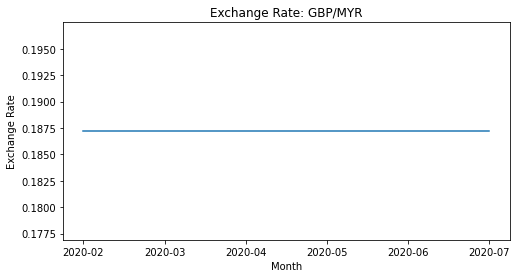

In [57]:
#visualize for the first currency
from matplotlib import pyplot as plt
x = analyzer_groupby_GBP['Month_Year'].astype(str)
y = analyzer_groupby_GBP['GBP_MYR']
plt.figure(figsize=(8,4))
plt.plot(x, y)
plt.title("Exchange Rate: GBP/MYR")
plt.xlabel("Month")
plt.ylabel("Exchange Rate")
plt.show()

In [60]:
#make a new dataframe that takes the mean of each month for the major currencies
groupby_all = analyzer.groupby('Month_Year').apply(lambda x: pd.Series
           ({
              'GBP_mean': x['GBP_MYR'].mean(),
              'AUD_mean': x['AUD_MYR'].mean(),
              'NZD_mean': x['NZD_MYR'].mean(),
              'CAD_mean': x['CAD_MYR'].mean(),
              'USD_mean': x['USD_MYR'].mean(),
              'CHF_mean': x['CHF_MYR'].mean(),
              'SGD_mean': x['SGD_MYR'].mean(),          
                                             })).reset_index()
groupby_all = pd.DataFrame(groupby_all)
groupby_all

,Month_Year,GBP_mean,AUD_mean,NZD_mean,CAD_mean,USD_mean,CHF_mean,SGD_mean
0,2020-02,0.1872,0.360767,0.375717,0.316483,0.237617,0.232517,NaN
1,2020-03,0.1872,0.374791,0.384978,0.324717,0.233013,0.223143,NaN
2,2020-04,0.1872,0.364327,0.382095,0.322973,0.229986,0.223082,NaN
3,2020-05,0.1872,0.354014,0.378548,0.322229,0.230605,0.223610,NaN
4,2020-06,0.1872,0.339114,0.362736,0.317041,0.234073,0.222682,NaN
5,2020-07,0.1872,0.336650,0.357517,0.317200,0.233767,0.220567,NaN


In [63]:
#Plot the data using bokeh for rich and creative visualization
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.models.annotations import Title
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Spectral10

from datetime import datetime

groupby_all['Month_Year'] = groupby_all['Month_Year'].astype(str)
groupby_all['Month_Year'] = pd.to_datetime(groupby_all['Month_Year'])

source = ColumnDataSource(groupby_all)

output_notebook()

p = figure(plot_height = 500, \
           plot_width = 900, \
           x_axis_type = 'datetime')

p.line(x='Month_Year', y='GBP_mean', legend_label = 'GBP_mean', source=source, color=Spectral10[1], line_width=4)
p.line(x='Month_Year', y='AUD_mean', legend_label = 'AUD_mean', source=source, color=Spectral10[2], line_width=4)
p.line(x='Month_Year', y='NZD_mean', legend_label = 'NZD_mean', source=source, color=Spectral10[3], line_width=4)
p.line(x='Month_Year', y='CAD_mean', legend_label = 'CAD_mean', source=source, color=Spectral10[4], line_width=4)
p.line(x='Month_Year', y='USD_mean', legend_label = 'USD_mean', source=source, color=Spectral10[9], line_width=4)
p.line(x='Month_Year', y='CHF_mean', legend_label = 'CHF_mean', source=source, color=Spectral10[6], line_width=4)
p.line(x='Month_Year', y='SGD_mean', legend_label = 'SGD_mean', source=source, color=Spectral10[7], line_width=4)


p.xaxis[0].ticker.desired_num_ticks = 10

p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Exchange Rate'

t = Title()
t.text = 'Exchange Rate: Top Countries/MYR'
p.title = t

hover = HoverTool(tooltips = [
                  ('GBP_mean','@GBP_mean'),\
                  ('AUD_mean', '@AUD_mean'),\
                  ('NZD_mean', '@NZD_mean'),\
                  ('CAD_mean', '@CAD_mean'),\
                  ('USD_mean', '@USD_mean'),\
                  ('CHF_mean', '@CHF_mean'),\
                  ('SGD_mean', '@SGD_mean')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

In [65]:
output_notebook()

Loading BokehJS ...